# 📓 Kaggle Notebook: 3D Classification from Point Clouds

Welcome! This notebook provides the **complete, end-to-end code** for performing 3D object classification using point cloud data.

---

## 📦 Step 0: Setup, Imports & Configuration

This initial block sets up our environment for the project.

### ✅ What we do in this step:
- Import all necessary libraries, including:
  - `os` and `glob` for navigating the file system
  - `numpy`, `torch`, and other core libraries for data processing and deep learning
- Define a `Config` class to store all key parameters in one place, such as:
  - Dataset paths
  - Batch size
  - Learning rate
  - Input size
  - Number of classes

Keeping all configuration values centralized makes the code **cleaner**, **easier to maintain**, and **simple to modify** during experimentation.


In [1]:
# --- Core Libraries ---
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from sklearn.model_selection import train_test_split
import json

# --- File System and Utilities ---
import os
import glob
from tqdm import tqdm
import re # For regular expressions to parse filenames

# --- Image & Vision Libraries ---
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models

# --- Visualization ---
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

# --- Configuration for all data types ---
class Config:
    # Root directory
    BASE_DIR = "/kaggle/input/modelnet40/modelnet40/"
    
    # Paths for each data modality
    PC_DIR = os.path.join(BASE_DIR, "point_cloud/")
    RGB_DIR = os.path.join(BASE_DIR, "rgb_imgs/")
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    BATCH_SIZE = 32
    NUM_WORKERS = 2
    EPOCHS = 25 # Multi-modal models can converge faster
    LEARNING_RATE = 0.001

CONFIG = Config()

print(f"✅ Setup complete. Using device: {CONFIG.DEVICE}")
print(f"Point Cloud Directory: {CONFIG.PC_DIR}")
print(f"RGB Image Directory: {CONFIG.RGB_DIR}")

✅ Setup complete. Using device: cuda:0
Point Cloud Directory: /kaggle/input/modelnet40/modelnet40/point_cloud/
RGB Image Directory: /kaggle/input/modelnet40/modelnet40/rgb_imgs/


## 🔍 Step 1: Multi-Modal Data Discovery

This is the most critical change in our pipeline.

Unlike traditional datasets where all data lives in a single file or folder, we now deal with **multi-modal data** spread across multiple subdirectories:
- 📦 `point_cloud/` — contains `.npy` files with 3D point clouds  
- 🖼️ `rgb_imgs/` — contains `.png` images rendered from the same 3D objects  

The challenge is that we need to **intelligently link related files** across these modalities.

### 🔑 Strategy:
- Use the `point_cloud/` folder as our **source of truth**
- For each file like `chair_PointCloud_000561.npy`, we:
  - Extract the **class** (`chair`) and the **ID** (`000561`)
  - Construct the expected RGB filename → `chair_RGBImg_000561.png`
  - Check if this image exists in `rgb_imgs/`
  - If so, we treat it as a **valid multi-modal pair**

### 📋 Output:
We store all valid (point cloud, RGB image, class label) triplets in a **Pandas DataFrame**.  
This makes it easy to:
- Shuffle and split the dataset
- Use for training multi-modal models
- Keep everything organized and queryable

This discovery step lays the foundation for all further data processing and modeling.


In [2]:
# --- Discover all point cloud files ---
all_pc_files = sorted(glob.glob(os.path.join(CONFIG.PC_DIR, "*.npy")))
print(f"Found {len(all_pc_files)} point cloud files.")

# --- Regex to parse filenames: e.g., "chair_PointCloud_000561.npy" ---
file_pattern = re.compile(r"([a-zA-Z_]+)_PointCloud_(\d+)\.npy")

matched_files = []

print("Searching for matching RGB images for each point cloud...")
for pc_path in tqdm(all_pc_files):
    match = file_pattern.match(os.path.basename(pc_path))
    if not match:
        continue
    
    class_name, file_id = match.groups()
    rgb_filename = f"{class_name}_RGBImg_{file_id}.png"
    rgb_path = os.path.join(CONFIG.RGB_DIR, rgb_filename)
    
    if os.path.exists(rgb_path):
        matched_files.append({
            "class": class_name,
            "id": file_id,
            "point_cloud_path": pc_path,
            "rgb_image_path": rgb_path
        })

# --- Create DataFrame ---
df = pd.DataFrame(matched_files)
print(f"\n✅ Found {len(df)} matching pairs of point clouds and RGB images.")

# --- Remove classes with fewer than 2 samples ---
class_counts = df['class'].value_counts()
valid_classes = class_counts[class_counts >= 2].index
df = df[df['class'].isin(valid_classes)]

# --- Create class-to-integer mapping ---
unique_labels = sorted(df['class'].unique())
class_to_int_map = {label: i for i, label in enumerate(unique_labels)}
df['label'] = df['class'].map(class_to_int_map)

CONFIG.NUM_CLASSES = len(unique_labels)
print(f"Found {CONFIG.NUM_CLASSES} unique classes (after filtering).")

# --- Train/Val Split ---
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['label']
)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
display(train_df.head())


Found 12311 point cloud files.
Searching for matching RGB images for each point cloud...


100%|██████████| 12311/12311 [00:08<00:00, 1482.67it/s]


✅ Found 482 matching pairs of point clouds and RGB images.
Found 31 unique classes (after filtering).
Training samples: 380
Validation samples: 95


,class,id,point_cloud_path,rgb_image_path,label
323,range_hood,010933,/kaggle/input/modelnet40/modelnet40/point_clou...,/kaggle/input/modelnet40/modelnet40/rgb_imgs/r...,23
51,bed,002288,/kaggle/input/modelnet40/modelnet40/point_clou...,/kaggle/input/modelnet40/modelnet40/rgb_imgs/b...,1
467,vase,003524,/kaggle/input/modelnet40/modelnet40/point_clou...,/kaggle/input/modelnet40/modelnet40/rgb_imgs/v...,30
369,sofa,003853,/kaggle/input/modelnet40/modelnet40/point_clou...,/kaggle/input/modelnet40/modelnet40/rgb_imgs/s...,24
279,monitor,003176,/kaggle/input/modelnet40/modelnet40/point_clou...,/kaggle/input/modelnet40/modelnet40/rgb_imgs/m...,18


### 📦 Step 2: The Multi-Modal Dataset Class

This new `Dataset` class is the **heart of our multi-modal pipeline**. It dynamically loads and returns a pair of aligned modalities (point cloud + image) for a single object.

#### 🧠 Workflow inside `__getitem__`

1. Extract the row from our DataFrame for index \( i \):
   \[
   \text{row} \leftarrow \texttt{df.iloc[i]}
   \]

2. Load the point cloud:
   \[
   \texttt{point\_cloud} \in \mathbb{R}^{N \times 3}
   \]

3. Load and transform the RGB image:
   - Resize: \( 224 \times 224 \)
   - Normalize:
     $$
     \mu = [0.485, 0.456, 0.406], \quad
     \sigma = [0.229, 0.224, 0.225]
     $$

4. Return a dictionary:
```python
{
    "point_cloud": point_tensor,
    "rgb_image": image_tensor,
    "label": label_int
}


In [3]:
class MultiModalDataset(Dataset):
    def __init__(self, dataframe, image_transforms):
        self.df = dataframe
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row from the dataframe
        row = self.df.iloc[idx]
        
        # --- Load Point Cloud ---
        pc_path = row['point_cloud_path']
        point_cloud = np.load(pc_path).astype(np.float32)
        
        # --- Load RGB Image ---
        img_path = row['rgb_image_path']
        image = Image.open(img_path).convert("RGB")
        
        # Apply image transformations
        image_tensor = self.image_transforms(image)
        
        # --- Get Label ---
        label = row['label']
        
        return {
            "point_cloud": torch.from_numpy(point_cloud),
            "rgb_image": image_tensor,
            "label": torch.tensor(label).long()
        }

# --- Define image transformations for our CNN ---
# We use standard transformations for models pre-trained on ImageNet.
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Create Datasets and DataLoaders ---
train_dataset = MultiModalDataset(train_df, image_transforms)
val_dataset = MultiModalDataset(val_df, image_transforms)

train_loader = DataLoader(train_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=True, num_workers=CONFIG.NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=CONFIG.BATCH_SIZE, shuffle=False, num_workers=CONFIG.NUM_WORKERS)

print("✅ Multi-modal DataLoaders created successfully.")

# Verify a batch
batch = next(iter(train_loader))
print(f"Point cloud batch shape: {batch['point_cloud'].shape}")
print(f"RGB image batch shape: {batch['rgb_image'].shape}")
print(f"Labels batch shape: {batch['label'].shape}")

✅ Multi-modal DataLoaders created successfully.
Point cloud batch shape: torch.Size([32, 1024, 3])
RGB image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])


### 🔧 Step 3: The Multi-Modal Model Architecture

In this section, we define our multi-modal neural network that combines information from both **RGB images** and **3D point clouds**.

The model is composed of **three main components**:

---

#### 🖼️ 1. Image Encoder

- We use a **pre-trained ResNet-18** from `torchvision.models`.
- The final classification layer is **removed**.
- This transforms each input image into a **512-dimensional** feature vector.

Mathematically:
\[
\text{Image Feature} \in \mathbb{R}^{512}
\]

---

#### 🌀 2. Point Cloud Encoder

- A simplified version of **PointNet**, specialized for 3D point data.
- It ingests \( N \times 3 \) tensors (where \( N \) is the number of points).
- Outputs a **512-dimensional** vector representing shape and spatial structure.

\[
\text{Point Cloud Feature} \in \mathbb{R}^{512}
\]

---

#### 🔗 3. Fusion and Classifier Head

- The two feature vectors are **concatenated** into a single 1024-dimensional representation:
\[
\text{Fused Feature} = [\text{Image Feature}; \text{Point Cloud Feature}] \in \mathbb{R}^{1024}
\]

- This fused feature is passed through a final set of **linear layers** to perform classification over all object classes (e.g., 40 for ModelNet40).

---

This fusion allows the model to leverage:
- **Geometry** from point clouds
- **Texture and color** from images  
for more accurate and robust 3D classification.


In [4]:
# --- Point Cloud Branch ---
class PointCloudEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super(PointCloudEncoder, self).__init__()
        self.conv1 = nn.Conv1d(3, 64, 1)
        self.conv2 = nn.Conv1d(64, 128, 1)
        self.conv3 = nn.Conv1d(128, output_dim, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = x.transpose(2, 1) # [B, 3, N]
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        x = torch.max(x, 2, keepdim=True)[0] # Global Max Pooling
        x = x.view(-1, 512)
        return x

# --- Image Branch ---
class ImageEncoder(nn.Module):
    def __init__(self, output_dim=512):
        super(ImageEncoder, self).__init__()
        # Use a pre-trained ResNet-18
        resnet = models.resnet18(pretrained=True)
        # Remove the final fully-connected layer (the classifier)
        self.features = nn.Sequential(*list(resnet.children())[:-1])
        # Freeze the pre-trained weights
        for param in self.features.parameters():
            param.requires_grad = False
        # Add a new layer to project to our desired output dimension
        self.projector = nn.Linear(resnet.fc.in_features, output_dim)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.projector(x)
        return x
        
# --- The Full Multi-Modal Network ---
class MultiModalNet(nn.Module):
    def __init__(self, num_classes, pc_dim=512, img_dim=512):
        super(MultiModalNet, self).__init__()
        self.pc_encoder = PointCloudEncoder(output_dim=pc_dim)
        self.img_encoder = ImageEncoder(output_dim=img_dim)
        
        # Classifier Head
        self.fusion_dim = pc_dim + img_dim
        self.fc1 = nn.Linear(self.fusion_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, pc, img):
        # Get features from each branch
        pc_features = self.pc_encoder(pc)
        img_features = self.img_encoder(img)
        
        # 2. Fuse the features by concatenation
        fused_features = torch.cat((pc_features, img_features), dim=1)
        
        # 3. Pass through the classifier head
        x = self.relu(self.fc1(fused_features))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = MultiModalNet(num_classes=CONFIG.NUM_CLASSES).to(CONFIG.DEVICE)
print("✅ Multi-modal model created successfully.")
# print(model) # Uncomment to see the full architecture

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 223MB/s]


✅ Multi-modal model created successfully.


### 🏋️ Step 4: The Training & Validation Loop

Our training loop follows the standard PyTorch pattern, with one important difference:

Because we are now using a **multi-modal dataset**, each batch from the `DataLoader` is a **dictionary** containing:

- `batch['point_cloud']`: the 3D point cloud tensor (shape: `B x N x 3`)
- `batch['rgb_image']`: the corresponding RGB image tensor (shape: `B x 3 x H x W`)
- `batch['label']`: the ground truth label

---

#### 🔁 Key Changes

- Each tensor must be moved to the **GPU** using `.to(device)` individually:
  ```python
  points = batch['point_cloud'].to(CONFIG.DEVICE)
  images = batch['rgb_image'].to(CONFIG.DEVICE)
  labels = batch['label'].to(CONFIG.DEVICE)


In [5]:
# --- Loss and Optimizer ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=CONFIG.LEARNING_RATE)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0.0

print("🚀 Starting training...")
for epoch in range(CONFIG.EPOCHS):
    # --- Training ---
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]"):
        pc = batch['point_cloud'].to(CONFIG.DEVICE)
        img = batch['rgb_image'].to(CONFIG.DEVICE)
        labels = batch['label'].to(CONFIG.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(pc, img)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * pc.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()

    # --- Validation ---
    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pc = batch['point_cloud'].to(CONFIG.DEVICE)
            img = batch['rgb_image'].to(CONFIG.DEVICE)
            labels = batch['label'].to(CONFIG.DEVICE)
            
            outputs = model(pc, img)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item() * pc.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # --- Log and Save ---
    epoch_train_acc = train_correct / train_total
    epoch_val_acc = val_correct / val_total
    print(f"Epoch {epoch+1}/{CONFIG.EPOCHS} | Train Acc: {epoch_train_acc:.4f} | Val Acc: {epoch_val_acc:.4f}")
    
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), 'multimodal_model.pth')
        print(f"🎉 New best model saved with Val Acc: {best_val_acc:.4f}")

print("✅ Training finished!")

🚀 Starting training...


Epoch 1 [Val]: 100%|██████████| 3/3 [00:00<00:00,  3.79it/s]


Epoch 1/25 | Train Acc: 0.2079 | Val Acc: 0.3684
🎉 New best model saved with Val Acc: 0.3684


Epoch 2 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.96it/s]


Epoch 2/25 | Train Acc: 0.3921 | Val Acc: 0.4842
🎉 New best model saved with Val Acc: 0.4842


Epoch 3 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.14it/s]


Epoch 3/25 | Train Acc: 0.5026 | Val Acc: 0.5158
🎉 New best model saved with Val Acc: 0.5158


Epoch 4 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]


Epoch 4/25 | Train Acc: 0.6421 | Val Acc: 0.6737
🎉 New best model saved with Val Acc: 0.6737


Epoch 5 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.73it/s]


Epoch 5/25 | Train Acc: 0.6132 | Val Acc: 0.7053
🎉 New best model saved with Val Acc: 0.7053


Epoch 6 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.76it/s]


Epoch 6/25 | Train Acc: 0.6868 | Val Acc: 0.7368
🎉 New best model saved with Val Acc: 0.7368


Epoch 7 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.33it/s]


Epoch 7/25 | Train Acc: 0.7211 | Val Acc: 0.7895
🎉 New best model saved with Val Acc: 0.7895


Epoch 8 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 8/25 | Train Acc: 0.7289 | Val Acc: 0.8000
🎉 New best model saved with Val Acc: 0.8000


Epoch 9 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.92it/s]


Epoch 9/25 | Train Acc: 0.7474 | Val Acc: 0.7789


Epoch 10 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]


Epoch 10/25 | Train Acc: 0.7895 | Val Acc: 0.8105
🎉 New best model saved with Val Acc: 0.8105


Epoch 11 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.59it/s]


Epoch 11/25 | Train Acc: 0.7895 | Val Acc: 0.8105


Epoch 12 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.82it/s]


Epoch 12/25 | Train Acc: 0.8553 | Val Acc: 0.8000


Epoch 13 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]


Epoch 13/25 | Train Acc: 0.8737 | Val Acc: 0.8316
🎉 New best model saved with Val Acc: 0.8316


Epoch 14 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.25it/s]


Epoch 14/25 | Train Acc: 0.8868 | Val Acc: 0.8737
🎉 New best model saved with Val Acc: 0.8737


Epoch 15 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.60it/s]


Epoch 15/25 | Train Acc: 0.8658 | Val Acc: 0.8316


Epoch 16 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 16/25 | Train Acc: 0.8868 | Val Acc: 0.8632


Epoch 17 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.55it/s]


Epoch 17/25 | Train Acc: 0.8868 | Val Acc: 0.8526


Epoch 18 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch 18/25 | Train Acc: 0.8947 | Val Acc: 0.8316


Epoch 19 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]


Epoch 19/25 | Train Acc: 0.9132 | Val Acc: 0.8632


Epoch 20 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.24it/s]


Epoch 20/25 | Train Acc: 0.9158 | Val Acc: 0.8632


Epoch 21 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.12it/s]


Epoch 21/25 | Train Acc: 0.9263 | Val Acc: 0.8211


Epoch 22 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.66it/s]


Epoch 22/25 | Train Acc: 0.9053 | Val Acc: 0.8526


Epoch 23 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.35it/s]


Epoch 23/25 | Train Acc: 0.9053 | Val Acc: 0.8316


Epoch 24 [Val]: 100%|██████████| 3/3 [00:00<00:00,  6.84it/s]


Epoch 24/25 | Train Acc: 0.8895 | Val Acc: 0.8421


Epoch 25 [Val]: 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

Epoch 25/25 | Train Acc: 0.9447 | Val Acc: 0.8000
✅ Training finished!


### 📊 Step 5: Analysis and Multi-Modal Visualization

Now that our model is trained, it's time to **visualize what it's seeing**. Since we have both **3D structure** (point cloud) and **2D appearance** (RGB image), we can showcase the power of multi-modal learning.

---

#### 🔍 What We'll Do:

- Pick a **random sample** from the validation set.
- Display:
  - The **RGB image** using `matplotlib`
  - The **3D point cloud** using `plotly`
- Pass both modalities through our model to generate a prediction.
- Print both the **true label** and the **predicted label**.

---

This step provides a **qualitative evaluation** of the model’s reasoning — seeing both the input and the model’s output helps us better understand any successes or failures.

📌 This is especially useful when diagnosing **misclassifications** — Was the shape misleading? Did the image lack texture? Multi-modal visualization helps answer that.



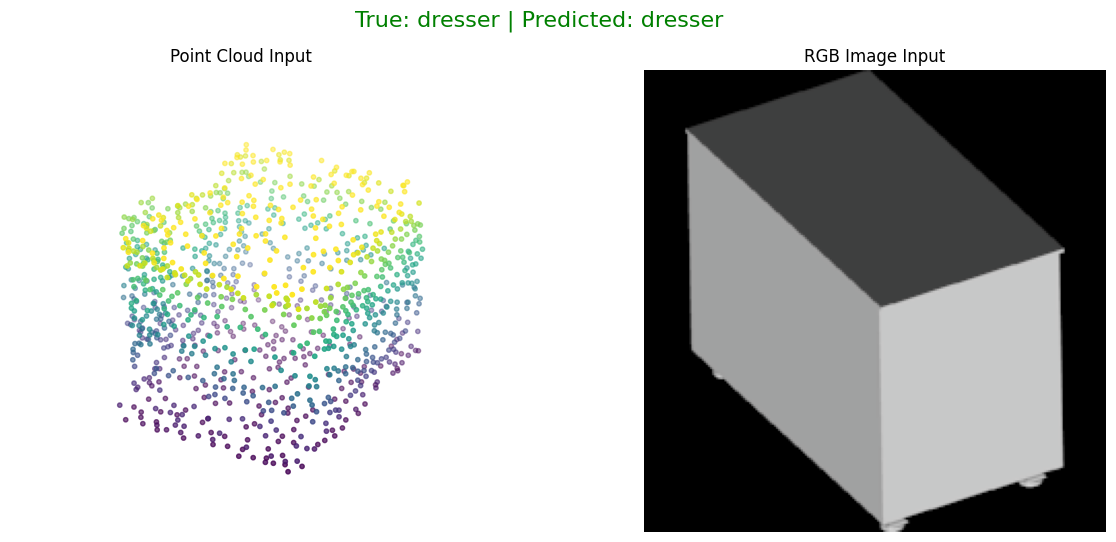

In [7]:
# --- Load the best saved model ---
best_model = MultiModalNet(num_classes=CONFIG.NUM_CLASSES).to(CONFIG.DEVICE)
best_model.load_state_dict(torch.load('multimodal_model.pth'))
best_model.eval()

# --- Get a random sample from the validation set ---
sample_idx = np.random.randint(0, len(val_dataset))
sample = val_dataset[sample_idx]

pc_tensor = sample['point_cloud'].unsqueeze(0).to(CONFIG.DEVICE)
img_tensor = sample['rgb_image'].unsqueeze(0).to(CONFIG.DEVICE)
true_label_idx = sample['label'].item()

# --- Get Model Prediction ---
inv_class_map = {v: k for k, v in class_to_int_map.items()}
with torch.no_grad():
    output = best_model(pc_tensor, img_tensor)
    pred_label_idx = torch.max(output, 1)[1].item()

true_label_name = inv_class_map[true_label_idx]
pred_label_name = inv_class_map[pred_label_idx]
result_color = 'green' if true_label_name == pred_label_name else 'red'

# --- Create Visualization ---
fig = plt.figure(figsize=(15, 6))
title = f"True: {true_label_name} | Predicted: {pred_label_name}"
fig.suptitle(title, fontsize=16, color=result_color)

# --- Plot Point Cloud ---
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
pc = sample['point_cloud'].numpy()
ax1.scatter(pc[:, 0], pc[:, 1], pc[:, 2], s=10, c=pc[:, 2], cmap='viridis')
ax1.set_title("Point Cloud Input")
ax1.axis('off')

# --- Plot RGB Image ---
ax2 = fig.add_subplot(1, 2, 2)
# We need to un-normalize the image tensor for display
img_display = sample['rgb_image'].numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
img_display = std * img_display + mean
img_display = np.clip(img_display, 0, 1)
ax2.imshow(img_display)
ax2.set_title("RGB Image Input")
ax2.axis('off')

plt.show()